In [73]:
# !pip install MTCFeatures

In [74]:
import MTCFeatures
from MTCFeatures import MTCFeatureLoader
import pandas as pd

In [75]:
# MTCFeatures.downloadData(dest='user')

In [76]:
fl = MTCFeatureLoader('MTC-FS-INST-2.0')
seqs = fl.sequences()

In [77]:
%%time
phrase_data = []
for ii, x in enumerate(seqs):
    phrase_data.append({
        'id': x['id'],
        **x['features']
    })

EOFError: Compressed file ended before the end-of-stream marker was reached

# On commence par étudier les données

In [78]:
df_phrase = pd.DataFrame(phrase_data)
df_phrase.shape # (13492, 62)

(13492, 62)

In [79]:
import numpy as np

In [80]:
# Chaque ligne du set représente une mélodie, représentée par des features.

print(np.array(df_phrase['pitch'][0]).shape) # pitch représente la hauteur des notes
print(np.array(df_phrase['duration'][0]).shape) # duration représente la durée des notes
print(np.array(df_phrase['phrase_end'][0]).shape) # phrase_end dit si la note est la dernière de la phrase

print(df_phrase['pitch'][0])
print(df_phrase['duration'][0])
print(df_phrase['phrase_end'][0])
# On peut donc voir que chacun de ses 3 features est une liste de la même longueur que le nombre de notes dans la mélodie.

# combien de fin de phrase dans le premier exemple ?

print(np.sum(df_phrase['phrase_end'][0])) # 4

# On pense découpere les séquences en sous séquences par notes avec un nombre fixe de notes par sous séquence. On pourra tester de diviser les séquences en sous séquences de nombre 
# fixe de note pour toutes les séquences ou bien de diviser les séquences par un nombre fixe pour toutes les séquences.

print(df_phrase['beat'][0]) # beat représente le temps de la note dans la mesure

# On peut aussi faire des sous séquences basées sur les mesures pour éviter de couper une mesure en deux.

print(df_phrase['beat_fraction_str'][0]) # beat_fraction_str représente le temps de la note dans la mesure sous forme de fraction


(44,)
(44,)
(44,)
['E4', 'C4', 'A3', 'G3', 'C4', 'C4', 'D4', 'C4', 'D4', 'E4', 'A3', 'G3', 'G3', 'F#3', 'G3', 'A3', 'F4', 'E4', 'D4', 'E4', 'D4', 'G3', 'D4', 'E4', 'D4', 'C4', 'A3', 'G3', 'E4', 'F4', 'E4', 'A3', 'E4', 'D4', 'G3', 'A3', 'G3', 'G3', 'F4', 'E4', 'D4', 'A3', 'B3', 'C4']
[1.0, 0.5, 0.5, 0.75, 0.25, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 0.5, 0.5, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 0.5, 0.5, 1.5]
[False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, True]
4
[1.0, 2.0, 2.5, 1.0, 1.75, 2.0, 1.0, 2.0, 2.5, 1.0, 1.5, 2.0, 1.0, 2.0, 2.5, 1.0, 1.5, 2.0, 1.0, 2.0, 2.5, 1.0, 1.0, 2.0, 2.5, 1.0, 1.5, 2.0, 1.0, 2.0, 2.5, 1.0, 1.5, 2.0, 1.0, 2.0, 2.5,

In [81]:
# print(df_phrase.describe()) # Pas utile pour les features qui sont des listes et trop long, ça sert à r ici

In [82]:
# df_phrase.info() # 7302 sequences avec paroles

In [83]:
for col in df_phrase.columns:
    t = type(df_phrase[col][0])
    if t != list:
        print(col, t)

# On cherche les colonnes qui ne sont pas des listes

id <class 'str'>
lyrics <class 'float'>
noncontentword <class 'float'>
wordend <class 'float'>
phoneme <class 'float'>
rhymes <class 'float'>
rhymescontentwords <class 'float'>
wordstress <class 'float'>
melismastate <class 'float'>


7302 séquences avec des paroles

In [84]:
from tqdm import tqdm

In [85]:
def generate_subsequences(df, length=8):
    """
    Divise les colonnes de type liste d'un DataFrame en sous-séquences de taille `length`,
    en excluant les sous-séquences dont la longueur est inférieure à `length`.

    Args:
        df (pd.DataFrame): Le DataFrame d'entrée contenant des colonnes avec des listes.
        length (int): La longueur des sous-séquences souhaitées.

    Returns:
        pd.DataFrame: Un nouveau DataFrame contenant les sous-séquences comme lignes.
    """
    subsequences = []

    #on itere sur toutes les lignes de notre dataframe (donc sur chaque séquence)
    for _, row in df.iterrows():
        # dans les valeurs pour chaque attribut, on récupère la liste de taille minimale de notre séquence actuelle
        # pour ne pas avoir une sous séquence ou il n'y aura plus de valeurs à récupérer
        min_length = min(len(row[col]) for col in df.columns)

        # on prend portion par portion de notes ( longueur length ) pour diviser notre séquence
        for start_idx in range(0, min_length, length):
            # pour chaque portion de notes on créé notre sous séquence en reprenant les valeurs pour chaque attributs mais 
            # aux indices de la portion de notes qui nous interesse
            subsequence = {
                col: row[col][start_idx:start_idx + length]
                for col in df.columns
            }
            # si toutes les valeurs sont complétées, on peut ajouter la sous séquence à notre liste de sous sequences
            if all(len(subsequence[col]) == length for col in df.columns):
                subsequences.append(subsequence)

    # on en créé un dataframe
    return pd.DataFrame(subsequences)

### La cellule du dessous montre un test pour voir toutes les valeurs possibles dans les listes d'une colone. Value_counts() ne fonctionne pas car les attributs sont des listes.

In [86]:
# toutes les valeurs possibles de la colonne 'timesignature' dans le DataFrame
timesignature = []
for x in df_phrase['timesignature']:
    for y in x:
        if y not in timesignature:
            timesignature.append(y)
print(timesignature)

['2/4', '4/4', '6/8', '3/4', '3/8', '5/8', '7/8', '2/2', '12/8', '8/16', None, '6/4', '3/2', '3/16', '9/8', '9/4', '4/2', '5/4', '4/8', '8/8', '10/8', '2/8', '1/4', '7/4', '22/8', '2/16', '8/4', '13/8', '19/16', '6/2', '1/2', '2/1', '10/4', '10/2', '12/2', '16/2', '5/2']


## On continue d'analyser les données

In [87]:
i = 1
j = 0

print("midipitch:", df_phrase['midipitch'][i][:])
print("chromaticinterval:", df_phrase['chromaticinterval'][i][:])
print("tonic:", df_phrase['tonic'][i][:])
print("mode:", df_phrase['mode'][i][:])

# print("scaledegree:", df_phrase['scaledegree'][i][:])
print("timesignature:", df_phrase['timesignature'][i][:])
print("beatstrength:", df_phrase['beatstrength'][i][:])
# print("metriccontour:", df_phrase['metriccontour'][i][:])
# print("imaweight:", df_phrase['imaweight'][i][:])
# print("imacontour:", df_phrase['imacontour'][i][:])
print("=====================================")
print("duration:", df_phrase['duration'][i][:])
# print("duration_frac:", df_phrase['duration_frac'][i][:])
# print("duration_fullname:", df_phrase['duration_fullname'][i][:])
print("durationcontour:", df_phrase['durationcontour'][i][:])
print("IOI:", df_phrase['IOI'][i][:])
print("IOR:", df_phrase['IOR'][i][:])
# print("onsettick:", df_phrase['onsettick'][i][:]) # onsettick représente le temps de la note en ticks mais ne sert pas dans notre cas car ne donne aucune information utiles, comme un ID

print("=====================================")
print("beatfraction:", df_phrase['beatfraction'][i][:]) # durée de la note
print("beat_str:", df_phrase['beat_str'][i][:])
print("beat_fraction_str:", df_phrase['beat_fraction_str'][i][:])
print("beat:", df_phrase['beat'][i][:]) # beat_str + beat_fraction_str
# print("songpos:", df_phrase['songpos'][i][:]) # position de la note dans la chanson similaire à onsettick

print("=====================================")
# print("beatinsong:", df_phrase['beatinsong'][i][:]) # meme chose que pour songpos et onsettick
# print("nextisrest:", df_phrase['nextisrest'][i][:])
print("restduration_frac:", df_phrase['restduration_frac'][i][:]) # plus précis que nextisrest
print("phrase_ix:", df_phrase['phrase_ix'][i][:]) #numero de la phrase, inutile (id)
print("=====================================")
print("phrasepos", df_phrase['phrasepos'][i][:]) # position de la note dans la phrase
print("phrase_end", df_phrase['phrase_end'][i][:]) # indique si la note est la fin de la phrase
print("=====================================")
print("beatinphrase", df_phrase['beatinphrase'][i][:]) 
print("beatinphrase_end", df_phrase['beatinphrase_end'][i][:])
print("=====================================")
print("melismastate", df_phrase['melismastate'][i])

midipitch: [72, 73, 74, 72, 70, 69, 65, 69, 69, 69, 69, 74, 72, 60, 62, 64, 65, 67, 69, 70, 72, 74, 76, 79, 79, 79, 79, 60, 65, 67, 69, 69, 69, 60, 65, 67, 69, 69, 69, 72, 74, 72, 67, 69, 70, 69, 69, 60, 65, 67, 69, 69, 69, 60, 65, 67, 67, 69, 72, 74, 72, 67, 67, 72, 70, 67, 65, 74, 74, 76, 77, 76, 77, 74, 72, 69, 70, 70, 72, 67, 69, 70, 67, 69, 74, 72, 74, 74, 76, 77, 76, 77, 74, 72, 69, 69, 69, 67, 74, 72, 64, 65, 72, 72, 72, 74, 72, 70, 67, 65, 69, 69, 69, 69, 69, 67, 70, 70, 70, 70, 70, 69, 72, 72, 72, 72, 72, 72, 74, 72, 70, 67, 65, 69, 69, 69, 69, 69, 67, 74, 72, 64, 65]
chromaticinterval: [None, 1, 1, -2, -2, -1, -4, 4, 0, 0, 0, 5, -2, -12, 2, 2, 1, 2, 2, 1, 2, 2, 2, 3, 0, 0, 0, -19, 5, 2, 2, 0, 0, -9, 5, 2, 2, 0, 0, 3, 2, -2, -5, 2, 1, -1, 0, -9, 5, 2, 2, 0, 0, -9, 5, 2, 0, 2, 3, 2, -2, -5, 0, 5, -2, -3, -2, 9, 0, 2, 1, -1, 1, -3, -2, -3, 1, 0, 2, -5, 2, 1, -3, 2, 5, -2, 2, 0, 2, 1, -1, 1, -3, -2, -3, 0, 0, -2, 7, -2, -8, 1, 7, 0, 0, 2, -2, -2, -3, -2, 4, 0, 0, 0, 0, -2, 3, 0, 

Les attributs phrasepos et phrase_end donnent explicitement une indication sur la fin de phrase. beatinphrase et beatinphrase_end donnent également des indications explicites sur le début et la fin des phrases. 

on remarque qu'il y a des features qui sont équivalentes comme le `pitch` et le `midipitch`. Ce dernier n'est qu'une représentation du premier en midi, c'est-à-dire en entier. On pourra donc omettre le pitch et ne garder que le midipitch car il est plus simple à manipuler.

on a C5 = 72 et C#5 = 73 car c'est la note juste après C5

On doit chercher toutes les features qui sont corrélées pour ne pas utiliser des features inutiles

# liste des features corrélées selon la doc : 

[`pitch`, `midipitch`, `pitch40`, `diatonicpitch`] -> `midipitch` : hauteur de la note

[`contour3`, `contour5`, `diatonicinterval`, `chromaticinterval`] -> `chromaticinterval` : variation par rapport à la note précédente

[`tonic`] -> `tonic`

[`mode`] -> `mode`

[`scaledegree`, `scaledegreespecifier`] -> `scaledegree` : peut-être les 2 ?

[`timesignature`] -> `timesignature`

[`beatstrength`] -> `beatstrength`

[`mtriccontour`] -> `metriccontour`

[`imaweight`] -> `imaweight`

[`imacontour`] -> `imacontour`

[`duration`, `duration_frac`, `duration_fullname`] -> `duration` : durée de la note (forme de fraction et nom chaine de caractère)

[`durationcontour`] -> `durationcontour`

[`IOI`, `IOI_frac`] -> `IOI`

[`IOR`, `IOR_frac`] -> `IOR` : ratio entre IOI précédent et IOI actuel

[`beatfraction`] -> `beatfraction` : durée de la note

[`beat_fraction_str`, `beat_str`, `beat`] -> `beat` : `beat_fraction_str` + `beat_str`

[`nextisrest`, `restduration_frac`] -> `restduration_frac` : pause qui suit la note

[`phrasepos`, `phrase_end`] -> `phrase_pos` : fin de la phrase

[`beatinphrase`, `beatinphrase_end`] -> les deux sont similaires, donne info sur fin de phrase donc peut être à ne pas prendre en compte







[`onsettick`, `songpos`, `beatinsong`, `phrase_ix`] -> aucune features utile












# premiere selection des features

In [88]:
features = np.array(['midipitch', 'chromaticinterval', 'scaledegree', 'timesignature', 'beatstrength', 'metriccontour', 'imaweight', 'imacontour', 'duration', 'durationcontour', 'beatfraction', 'beat', 'restduration_frac', 'phrase_end'])
new_df = df_phrase[features]


# On découpe notre dataset en sous sequences de 8 notes

In [89]:
sub_seqs_df = generate_subsequences(new_df, length=8)

sub_seqs_df.head()

,midipitch,chromaticinterval,scaledegree,timesignature,beatstrength,metriccontour,imaweight,imacontour,duration,durationcontour,beatfraction,beat,restduration_frac,phrase_end
0,"[64, 60, 57, 55, 60, 60, 62, 60]","[None, -4, -3, -2, 5, 0, 2, -2]","[3, 1, 6, 5, 1, 1, 2, 1]","[2/4, 2/4, 2/4, 2/4, 2/4, 2/4, 2/4, 2/4]","[1.0, 0.5, 0.25, 1.0, 0.125, 0.5, 1.0, 0.5]","[None, -, -, +, -, +, +, -]","[0.798013, 0.663907, 0.150662, 0.945364, 0.013...","[None, -, -, +, -, +, +, -]","[1.0, 0.5, 0.5, 0.75, 0.25, 1.0, 1.0, 0.5]","[None, -, =, +, -, +, =, -]","[1, 1/2, 1/2, 3/4, 1/4, 1, 1, 1/2]","[1.0, 2.0, 2.5, 1.0, 1.75, 2.0, 1.0, 2.0]","[None, None, None, None, None, None, None, None]","[False, False, False, False, False, False, Fal..."
1,"[62, 64, 57, 55, 55, 54, 55, 57]","[2, 2, -7, -2, 0, -1, 1, 2]","[2, 3, 6, 5, 5, 4, 5, 6]","[2/4, 2/4, 2/4, 2/4, 2/4, 2/4, 2/4, 2/4]","[0.25, 1.0, 0.25, 0.5, 1.0, 0.5, 0.25, 1.0]","[-, +, -, +, +, -, -, +]","[0.195364, 0.812914, 0.162252, 0.627483, 0.951...","[-, +, -, +, +, -, -, +]","[0.5, 0.5, 0.5, 1.0, 1.0, 0.5, 0.5, 0.5]","[=, =, =, +, =, -, =, =]","[1/2, 1/2, 1/2, 1, 1, 1/2, 1/2, 1/2]","[2.5, 1.0, 1.5, 2.0, 1.0, 2.0, 2.5, 1.0]","[None, None, None, None, None, None, None, None]","[False, False, False, True, False, False, Fals..."
2,"[65, 64, 62, 64, 62, 55, 62, 64]","[8, -1, -2, 2, -2, -7, 7, 2]","[4, 3, 2, 3, 2, 5, 2, 3]","[2/4, 2/4, 2/4, 2/4, 2/4, 2/4, 2/4, 2/4]","[0.25, 0.5, 1.0, 0.5, 0.25, 1.0, 1.0, 0.5]","[-, +, +, -, -, +, =, -]","[0.183775, 0.642384, 0.837748, 0.692053, 0.25,...","[-, +, +, -, -, +, -, -]","[0.5, 1.0, 1.0, 0.5, 0.5, 1.0, 1.0, 0.5]","[=, +, =, -, =, +, =, -]","[1/2, 1, 1, 1/2, 1/2, 1, 1, 1/2]","[1.5, 2.0, 1.0, 2.0, 2.5, 1.0, 1.0, 2.0]","[None, None, None, None, None, 1, None, None]","[False, False, False, False, False, True, Fals..."
3,"[62, 60, 57, 55, 64, 65, 64, 57]","[-2, -2, -3, -2, 9, 1, -1, -7]","[2, 1, 6, 5, 3, 4, 3, 6]","[2/4, 2/4, 2/4, 2/4, 2/4, 2/4, 2/4, 2/4]","[0.25, 1.0, 0.25, 0.5, 1.0, 0.5, 0.25, 1.0]","[-, +, -, +, +, -, -, +]","[0.243377, 0.870861, 0.205298, 0.630795, 0.917...","[-, +, -, +, +, -, -, +]","[0.5, 0.5, 0.5, 1.0, 1.0, 0.5, 0.5, 0.5]","[=, =, =, +, =, -, =, =]","[1/2, 1/2, 1/2, 1, 1, 1/2, 1/2, 1/2]","[2.5, 1.0, 1.5, 2.0, 1.0, 2.0, 2.5, 1.0]","[None, None, None, None, None, None, None, None]","[False, False, False, False, False, False, Fal..."
4,"[64, 62, 55, 57, 55, 55, 65, 64]","[7, -2, -7, 2, -2, 0, 10, -1]","[3, 2, 5, 6, 5, 5, 4, 3]","[2/4, 2/4, 2/4, 2/4, 2/4, 2/4, 2/4, 2/4]","[0.25, 0.5, 1.0, 0.5, 0.25, 1.0, 0.25, 0.5]","[-, +, +, -, -, +, -, +]","[0.162252, 0.652318, 0.84106, 0.652318, 0.1837...","[-, +, +, -, -, +, -, +]","[0.5, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 1.0]","[=, +, =, -, =, =, =, +]","[1/2, 1, 1, 1/2, 1/2, 1/2, 1/2, 1]","[1.5, 2.0, 1.0, 2.0, 2.5, 1.0, 1.5, 2.0]","[None, None, None, None, None, None, None, None]","[False, True, False, False, False, False, Fals..."


# Certaines features ne sont pas des listes de valeur mais des strings. On va les transformer en valeur numérique

In [90]:
from sklearn.preprocessing import OneHotEncoder
from fractions import Fraction

def transform_features(df):
    """
    Transforme les features qui ne sont pas des listes de nombres en listes de nombres.

    Transformations spécifiques :
    - 'chromaticinterval': remplace None par 0.
    - 'tonic': encode les valeurs en vecteurs binaires selon 21 possibilités.
    - 'mode': encode les valeurs en vecteurs binaires selon 6 possibilités.
    - 'timesignature': convertit les fractions en nombres décimaux.
    - 'beatfraction': convertit les fractions en nombres décimaux.
    - 'metriccontour', 'imacontour', 'durationcontour': transforme les chaînes en 1, -1 ou 0.
    - 'restduration_frac': convertit les fractions en nombres décimaux, remplace None par 0.0.

    Args:
        df (pd.DataFrame): Le DataFrame d'entrée.

    Returns:
        pd.DataFrame: Le DataFrame transformé.
    """
    if 'chromaticinterval' in df.columns:
        print("chromaticinterval")
        df['chromaticinterval'] = df['chromaticinterval'].apply(
            lambda lst: [0 if val is None else val for val in lst]
        )

    if 'beatstrength' in df.columns:
        print("beatstrength")
        df['beatstrength'] = df['beatstrength'].apply(
            lambda lst: [0 if val is None else val for val in lst]
        )

    if 'beat' in df.columns:
        print("beat")
        df['beat'] = df['beat'].apply(
            lambda lst: [0 if val is None else val for val in lst]
        )

    if 'tonic' in df.columns:
        print("tonic")
        notes = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
        alterations = ['-', '', '#']
        possible_tonics = [n + a for n in notes for a in alterations]
        encoder = OneHotEncoder(categories=[possible_tonics], sparse_output=False, handle_unknown='ignore')

        def encode_tonic(tonic_list):
            encoded = encoder.fit_transform(np.array(tonic_list).reshape(-1, 1))
            return encoded.tolist()

        df['tonic'] = df['tonic'].apply(encode_tonic)

    if 'mode' in df.columns:
        print("mode")
        possible_modes = ['major', 'minor', 'dorian', 'phrygian', 'lydian', 'mixolydian']
        encoder = OneHotEncoder(categories=[possible_modes], sparse_output=False, handle_unknown='ignore')

        def encode_mode(mode_list):
            encoded = encoder.fit_transform(np.array(mode_list).reshape(-1, 1))
            return encoded.tolist()

        df['mode'] = df['mode'].apply(encode_mode)

    if 'timesignature' in df.columns:
        print("timesignature")
        df['timesignature'] = df['timesignature'].apply(
            lambda lst: [float(Fraction(val)) if val is not None else 0.0 for val in lst]
        )

    if 'beatfraction' in df.columns:
        print("beatfraction")
        df['beatfraction'] = df['beatfraction'].apply(
            lambda lst: [float(Fraction(val)) if val is not None else 0.0 for val in lst]
        )

    def transform_contour(contour_list):
        return [
            1 if val == '+' else -1 if val == '-' else 0 if val in ('=', None) else val
            for val in contour_list
        ]

    for contour_feature in ['metriccontour', 'imacontour', 'durationcontour']:
        if contour_feature in df.columns:
            print(contour_feature)
            df[contour_feature] = df[contour_feature].apply(transform_contour)

    if 'restduration_frac' in df.columns:
        print("restduration_frac")
        df['restduration_frac'] = df['restduration_frac'].apply(
            lambda lst: [float(Fraction(val)) if val is not None else 0.0 for val in lst]
        )

    return df

# deux types d'etiquettages possibles :

def transform_target_any(df): # on regarde si il y a une fin de phrase dans la sous séquence
    """
    Transforme la colonne 'phrase_end' en une seule valeur binaire. 1 si il y a une fin de phrase dans la sous séquence
    """
    if 'phrase_end' in df.columns:
        print("phrase_end")
        df['phrase_end'] = df['phrase_end'].apply(
            lambda lst: 1 if any(val == True for val in lst) else 0
        )

    return df

def transform_target_end(df): # on regarde si la fin de phrase est à la fin de la sous séquence
    """
    Transforme la colonne 'phrase_end' en une seule valeur binaire. 1 si il y a une fin de phrase à la fin de la séquence
    """
    if 'phrase_end' in df.columns:
        df['phrase_end'] = df['phrase_end'].apply(
            lambda lst: 1 if lst[-1] == True else 0
        )

    return df

def transform_target_hybrid(df, idx): 
    if 'phrase_end' in df.columns:
        df['phrase_end'] = df['phrase_end'].apply(
            lambda lst: 1 if lst[-1] == True else 0
        )


In [91]:
# data = {
#     'chromaticinterval': [[1, 2, None, 4], [None, 2, 3, 4]],
#     'tonic': [['C#', 'A-', 'B'], ['D', 'E', 'F#']],
#     'mode': [['major', 'minor'], ['lydian', 'mixolydian']],
#     'timesignature': [['1/4', '1/2', '3/4'], ['2/3', '1/8', '1/16']],
#     'beatfraction': [['1/12', '1/3', '5/6'], ['7/8', '1/6', '1/2']],
#     'metriccontour': [['+', '-', '='], ['-', '=', None]],
#     'imacontour': [['+', '=', '-'], ['=', None, '+']],
#     'durationcontour': [[None, '+', '-'], ['-', '+', '=']],
#     'restduration_frac': [['1/4', None, '3/8'], [None, '1/16', '1/2']],
#     'phrase_end': [[False, False, True], [False, False, False]]
# }
# df = pd.DataFrame(data)

# transformed_df = transform_features(df)

# for col in transformed_df.columns:
#     print(f"{col}:\n{transformed_df[col][1]}\n")

In [92]:
transformed_sub_seqs_df = transform_features(sub_seqs_df)
transformed_sub_seqs_df1 = transformed_sub_seqs_df.copy()
transformed_sub_seqs_df1 = transform_target_any(transformed_sub_seqs_df1)

chromaticinterval
beatstrength
beat
timesignature
beatfraction
metriccontour
imacontour
durationcontour
restduration_frac
phrase_end


# premier test de modèle

surtout pour voir si les features sont bien traitées

In [93]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# # Exemple : Fonction de transformation pour des données séquentielles
# def transform_sequence_features(df, sequence_columns):
#     """
#     Transforme des colonnes contenant des listes ou vecteurs en statistiques globales.
#     """
#     transformed_features = {}
#     for col in sequence_columns:
#         transformed_features[f'{col}_mean'] = df[col].apply(np.mean)
#         transformed_features[f'{col}_std'] = df[col].apply(np.std)
#         transformed_features[f'{col}_min'] = df[col].apply(np.min)
#         transformed_features[f'{col}_max'] = df[col].apply(np.max)
#     return pd.DataFrame(transformed_features)

# # Étape 1 : Charger les données
# sequence_columns = ['midipitch', 'chromaticinterval', 'scaledegree', 
#                     'beatstrength', 'metriccontour', 'duration']
# target_column = 'phrase_end'

# # Transformer les données
# transformed_df = transform_sequence_features(transformed_sub_seqs_df, sequence_columns)
# transformed_df['phrase_end'] = transformed_sub_seqs_df[target_column]

# # Séparer les données en X et y
# X = transformed_df.drop(columns=['phrase_end'])
# y = transformed_df['phrase_end']

# # Diviser en jeu d'entraînement et de test
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Étape 2 : Tester plusieurs modèles
# models = {
#     'Logistic Regression': LogisticRegression(max_iter=1000),
#     'SVM': SVC(),
#     'Random Forest': RandomForestClassifier(n_estimators=100),
#     'KNN': KNeighborsClassifier(),
# }

# # Étape 3 : Entraîner et évaluer chaque modèle
# for name, model in models.items():
#     pipeline = Pipeline([
#         ('scaler', StandardScaler()),
#         ('model', model)
#     ])
#     pipeline.fit(X_train, y_train)
#     y_pred = pipeline.predict(X_test)
#     print(f"{name}:")
#     print(classification_report(y_test, y_pred))
#     print("-" * 30)


In [94]:
# print(models['Random Forest'].score(X_test, y_test))
# print(models['Logistic Regression'].score(X_test, y_test))
# print(models['SVM'].score(X_test, y_test))
# print(models['KNN'].score(X_test, y_test))

# comme on a des liste de features, on va les aplatir pour pouvoir les utiliser dans un modèle

In [95]:
import pandas as pd

def flatten_row(row):
    flattened = {}
    for attr, values in row.items():
        if isinstance(values, list):  # Si la valeur est une liste
            for i, val in enumerate(values):
                flattened[f"{attr}_{i}"] = val
        else:
            flattened[attr] = values  # Si ce n'est pas une liste
    return flattened

def flatten_dataframe(data):
    flattened_rows = [flatten_row(row) for _, row in data.iterrows()]
    return pd.DataFrame(flattened_rows)



In [96]:
# Exemple de données
data = pd.DataFrame([
    {'midipitch': [64, 60, 57], 'chromaticinterval': [0, -4, -3], 'phrase_end': 0},
    {'midipitch': [55, 60, 60], 'chromaticinterval': [-2, 4, -1], 'phrase_end': 1},
    {'midipitch': [62, 60], 'chromaticinterval': [1, -2], 'phrase_end': 0}
])

# Transformation
flattened_data = flatten_dataframe(data)
flattened_data

,midipitch_0,midipitch_1,midipitch_2,chromaticinterval_0,chromaticinterval_1,chromaticinterval_2,phrase_end
0,64,60,57.0,0,-4,-3.0,0
1,55,60,60.0,-2,4,-1.0,1
2,62,60,NaN,1,-2,NaN,0


In [97]:

transformed_sub_seqs_df_flattened1 = flatten_dataframe(transformed_sub_seqs_df1.drop(columns=['phrase_end']))
transformed_sub_seqs_df_flattened1['phrase_end'] = transformed_sub_seqs_df1['phrase_end']


# premier vrai modèle

test de plusieurs hyperparamètres pour voir lequel est le plus performant

In [98]:
# from sklearn.model_selection import train_test_split
# from sklearn.model_selection import cross_val_score
# from sklearn.neural_network import MLPClassifier
# import warnings
# warnings.filterwarnings("ignore")


# X = transformed_sub_seqs_df_flattened.drop(columns=['phrase_end'])
# y = transformed_sub_seqs_df_flattened['phrase_end']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# activation = ['tanh', 'relu']
# solver = ['sgd']
# alpha = [0.0001, 0.001, 0.01]
# learning_rate = ['constant']
# max_iter = [100, 200, 300, 400, 500]

# best_score = 0
# best_params = {}

# all_scores = []

# for act in activation:
#     for sol in solver:
#         for a in alpha:
#             for lr in learning_rate:
#                 for mi in max_iter:
#                     print(f"Training with activation={act}, solver={sol}, alpha={a}, learning_rate={lr}, max_iter={mi}")
#                     clf = MLPClassifier(activation=act, solver=sol, alpha=a, learning_rate=lr, max_iter=mi)
#                     scores = cross_val_score(clf, X_train, y_train, cv=5)
#                     score = scores.mean()
#                     all_scores.append((act, sol, a, lr, mi, score))
#                     if score > best_score:
#                         best_score = score
#                         best_params = {
#                             'activation': act,
#                             'solver': sol,
#                             'alpha': a,
#                             'learning_rate': lr,
#                             'max_iter': mi
#                         }

# print(best_score)
# print(best_params)









In [99]:
# all_scores

"""
[('tanh', 'sgd', 0.0001, 'constant', 100, 0.6331837211870238),
 ('tanh', 'sgd', 0.0001, 'constant', 200, 0.6267489099900372),
 ('tanh', 'sgd', 0.0001, 'constant', 300, 0.6267355570727817),
 ('tanh', 'sgd', 0.0001, 'constant', 400, 0.6269491582974394),
 ('tanh', 'sgd', 0.0001, 'constant', 500, 0.6266287524500326),
 ('tanh', 'sgd', 0.001, 'constant', 100, 0.6267489046428102),
 ('tanh', 'sgd', 0.001, 'constant', 200, 0.6343184927877938),
 ('tanh', 'sgd', 0.001, 'constant', 300, 0.629499054833051),
 ('tanh', 'sgd', 0.001, 'constant', 400, 0.6267489037516056),
 ('tanh', 'sgd', 0.001, 'constant', 500, 0.6285645377781148),
 ('tanh', 'sgd', 0.01, 'constant', 100, 0.6263483973335517),
 ('tanh', 'sgd', 0.01, 'constant', 200, 0.6268290061046619),
 ('tanh', 'sgd', 0.01, 'constant', 300, 0.6287914910288234),
 ('tanh', 'sgd', 0.01, 'constant', 400, 0.6267489046428102),
 ('tanh', 'sgd', 0.01, 'constant', 500, 0.6266287497764191),
 ('relu', 'sgd', 0.0001, 'constant', 100, 0.690443999872023),
 ('relu', 'sgd', 0.0001, 'constant', 200, 0.7056097171236659),
 ('relu', 'sgd', 0.0001, 'constant', 300, 0.6912850251172624),
 ('relu', 'sgd', 0.0001, 'constant', 400, 0.7004565239690791),
 ('relu', 'sgd', 0.0001, 'constant', 500, 0.7017247570108609),
 ('relu', 'sgd', 0.001, 'constant', 100, 0.7023924812996329),
 ('relu', 'sgd', 0.001, 'constant', 200, 0.6785339213381899),
 ('relu', 'sgd', 0.001, 'constant', 300, 0.6907110974301316),
 ('relu', 'sgd', 0.001, 'constant', 400, 0.6997759672264887),
 ('relu', 'sgd', 0.001, 'constant', 500, 0.7056500958178535),
 ('relu', 'sgd', 0.01, 'constant', 100, 0.6963313414615344),
 ('relu', 'sgd', 0.01, 'constant', 200, 0.6869056942532191),
 ('relu', 'sgd', 0.01, 'constant', 300, 0.6901091716619422),
 ('relu', 'sgd', 0.01, 'constant', 400, 0.6997354557428282),
 ('relu', 'sgd', 0.01, 'constant', 500, 0.701377864565254)]
 """

# relu meilleur que tanh, alpha = 0.0001, learning_rate = constant, max_iter = 200

"\n[('tanh', 'sgd', 0.0001, 'constant', 100, 0.6331837211870238),\n ('tanh', 'sgd', 0.0001, 'constant', 200, 0.6267489099900372),\n ('tanh', 'sgd', 0.0001, 'constant', 300, 0.6267355570727817),\n ('tanh', 'sgd', 0.0001, 'constant', 400, 0.6269491582974394),\n ('tanh', 'sgd', 0.0001, 'constant', 500, 0.6266287524500326),\n ('tanh', 'sgd', 0.001, 'constant', 100, 0.6267489046428102),\n ('tanh', 'sgd', 0.001, 'constant', 200, 0.6343184927877938),\n ('tanh', 'sgd', 0.001, 'constant', 300, 0.629499054833051),\n ('tanh', 'sgd', 0.001, 'constant', 400, 0.6267489037516056),\n ('tanh', 'sgd', 0.001, 'constant', 500, 0.6285645377781148),\n ('tanh', 'sgd', 0.01, 'constant', 100, 0.6263483973335517),\n ('tanh', 'sgd', 0.01, 'constant', 200, 0.6268290061046619),\n ('tanh', 'sgd', 0.01, 'constant', 300, 0.6287914910288234),\n ('tanh', 'sgd', 0.01, 'constant', 400, 0.6267489046428102),\n ('tanh', 'sgd', 0.01, 'constant', 500, 0.6266287497764191),\n ('relu', 'sgd', 0.0001, 'constant', 100, 0.690443999

# on se rend compte que notre premier étiqutage n'est pas forcément le meilleur

any n'est pas représentatif car une fin de phrase peut être n'importe où dans la séquence

on va donc essayer de trouver une autre méthode pour étiqueter les données

end : la sous séquence est une phrase si il y a une fin de phrase à la fin de la séquence

In [100]:
# Maintenant on ne va considérer comme des fins de phrase que les séquences qui ont une note en fin de phrase en fin de séquences
transformed_sub_seqs_df2 = transformed_sub_seqs_df.copy()
transformed_sub_seqs_df2 = transform_target_end(transformed_sub_seqs_df2)

print(transformed_sub_seqs_df1['phrase_end'].value_counts())
print(transformed_sub_seqs_df2['phrase_end'].value_counts())

transformed_sub_seqs_df_flattened2 = flatten_dataframe(transformed_sub_seqs_df2.drop(columns=['phrase_end']))
transformed_sub_seqs_df_flattened2['phrase_end'] = transformed_sub_seqs_df2['phrase_end']

print(transformed_sub_seqs_df_flattened2['phrase_end'].value_counts())


phrase_end
1    67102
0    39905
Name: count, dtype: int64
phrase_end
0    95065
1    11942
Name: count, dtype: int64
phrase_end
0    95065
1    11942
Name: count, dtype: int64


# deuxième modèle avec un autre étiquetage (end)

avec et sans scaler

on test les 2 étiquetages

In [101]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

# X1 = transformed_sub_seqs_df_flattened1.drop(columns=['phrase_end'])
# y1 = transformed_sub_seqs_df_flattened1['phrase_end']

# X2 = transformed_sub_seqs_df_flattened2.drop(columns=['phrase_end'])
# y2 = transformed_sub_seqs_df_flattened2['phrase_end']

# X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.3, random_state=42)
# X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=42)

# clf1 = MLPClassifier(activation='relu', solver='sgd', alpha=0.0001, learning_rate='constant', max_iter=200)
# clf1.fit(X_train1, y_train1)
# y_pred1 = clf1.predict(X_test1)
# print("Model 1")
# print(classification_report(y_test1, y_pred1))
# print(clf1.score(X_test1, y_test1))

# clf2 = MLPClassifier(activation='relu', solver='sgd', alpha=0.0001, learning_rate='constant', max_iter=200)

# clf2.fit(X_train2, y_train2)
# y_pred2 = clf2.predict(X_test2)
# print("Model 2")
# print(classification_report(y_test2, y_pred2))
# print(clf2.score(X_test2, y_test2))

# pipeline1 = Pipeline([
#     ('scaler', StandardScaler()),
#     ('mlp', MLPClassifier(activation='relu', solver='sgd', alpha=0.0001, learning_rate='constant', max_iter=200))
# ])

# pipeline1.fit(X_train1, y_train1)
# y_pred3 = pipeline1.predict(X_test1)
# print("Model 3")
# print(classification_report(y_test1, y_pred3))
# print(pipeline1.score(X_test1, y_test1))

# pipeline2 = Pipeline([
#     ('scaler', StandardScaler()),
#     ('mlp', MLPClassifier(activation='relu', solver='sgd', alpha=0.0001, learning_rate='constant', max_iter=200))
# ])

# pipeline2.fit(X_train2, y_train2)
# y_pred4 = pipeline2.predict(X_test2)
# print("Model 4")
# print(classification_report(y_test2, y_pred4))
# print(pipeline2.score(X_test2, y_test2))









on a testé avec et sans scaler

Meilleur score global avec le deuxieme etiquetage mais biaisé par la classe majoritaire

In [102]:
# show confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    title = title.replace(' ', '_').lower()
    plt.savefig(title + '.png')
    plt.show()

# plot_confusion_matrix(y_test1, y_pred1, 'Confusion matrix for model 1')
# plot_confusion_matrix(y_test2, y_pred2, 'Confusion matrix for model 2')
# plot_confusion_matrix(y_test1, y_pred3, 'Confusion matrix for model 3')
# plot_confusion_matrix(y_test2, y_pred4, 'Confusion matrix for model 4')

Model 1 - any-label - sans scaler :
```
              precision    recall  f1-score   support

           0       0.63      0.55      0.58     11942
           1       0.75      0.81      0.78     20161

    accuracy                           0.71     32103
   macro avg       0.69      0.68      0.68     32103
weighted avg       0.70      0.71      0.71     32103

0.7099648007974333
```
![confusion_matrix](confusion_matrix_for_model_1.png)

Model 2 - end-label - sans scaler
```
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     28593
           1       0.80      0.36      0.50      3510

    accuracy                           0.92     32103
   macro avg       0.86      0.67      0.73     32103
weighted avg       0.91      0.92      0.91     32103

0.9199451764632589
```
![confusion_matrix](confusion_matrix_for_model_2.png)

Model 3 - any-label - avec scaler
```
              precision    recall  f1-score   support

           0       0.72      0.64      0.68     11942
           1       0.80      0.85      0.82     20161

    accuracy                           0.77     32103
   macro avg       0.76      0.75      0.75     32103
weighted avg       0.77      0.77      0.77     32103

0.7724511727875899
```
![confusion_matrix](confusion_matrix_for_model_3.png)

Model 4 - end-label - avec scaler
```
              precision    recall  f1-score   support

           0       0.95      0.98      0.96     28593
           1       0.76      0.59      0.67      3510

    accuracy                           0.94     32103
   macro avg       0.86      0.78      0.81     32103
weighted avg       0.93      0.94      0.93     32103

0.9351150982774196
```
![confusion_matrix](confusion_matrix_for_model_4.png)

On remarque qu'en utilisant le scaler, on a de meilleurs résultats et surtout un meilleur recall pour la classe minoritaire. 

In [103]:
# on veut maintenant équilibrer les classes pour voir si ça améliore les résultats

def balance_classes(df):
    """
    Équilibre les classes en prenant un nombre égal d'exemples pour chaque classe.
    """
    class_0 = df[df['phrase_end'] == 0]
    class_1 = df[df['phrase_end'] == 1]

    min_length = min(len(class_0), len(class_1))

    balanced = pd.concat([class_0.sample(min_length, random_state=42), class_1.sample(min_length, random_state=42)])
    
    # on doit reset les index pour éviter les NaN lorsque l'on attribue les valeurs à y
    balanced = balanced.reset_index(drop=True)
    return balanced

# On s'est rendu compte que la classe majoritaire biasait les résultats. On va donc essayer de rééquilibrer les classes

nouveaux modèles avec les classes équilibrées sur les deux types d'étiquetage

phrase_end
0    39905
1    39905
Name: count, dtype: int64
phrase_end
0    11942
1    11942
Name: count, dtype: int64
Model 5
              precision    recall  f1-score   support

           0       0.74      0.76      0.75     12008
           1       0.76      0.74      0.75     11935

    accuracy                           0.75     23943
   macro avg       0.75      0.75      0.75     23943
weighted avg       0.75      0.75      0.75     23943

0.7497807292319258
Model 6
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      3579
           1       0.87      0.87      0.87      3587

    accuracy                           0.87      7166
   macro avg       0.87      0.87      0.87      7166
weighted avg       0.87      0.87      0.87      7166

0.86603404967904


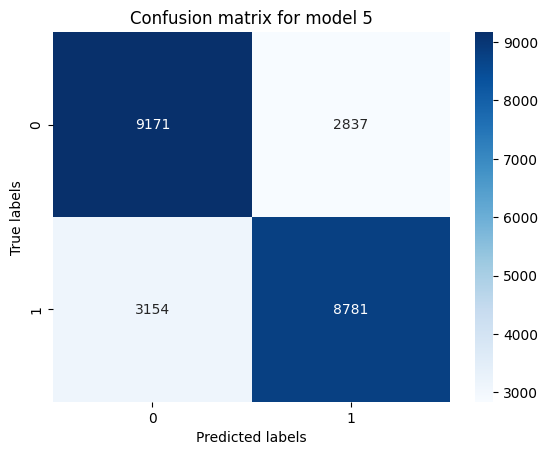

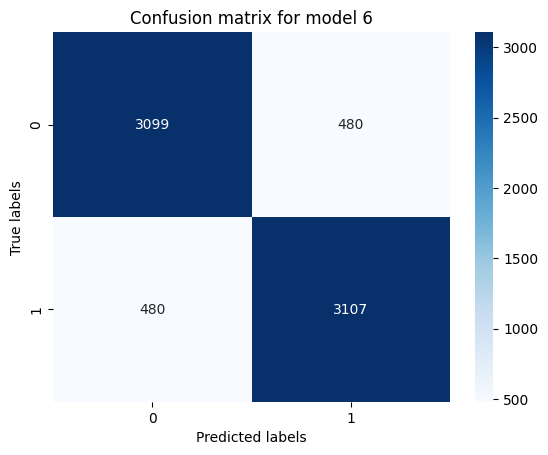

In [104]:
balanced_df1 = balance_classes(transformed_sub_seqs_df1)
balanced_df2 = balance_classes(transformed_sub_seqs_df2)

print(balanced_df1['phrase_end'].value_counts())
print(balanced_df2['phrase_end'].value_counts())


balanced_df_flattened1 = flatten_dataframe(balanced_df1.drop(columns=['phrase_end']))
balanced_df_flattened1['phrase_end'] = balanced_df1['phrase_end']

balanced_df_flattened2 = flatten_dataframe(balanced_df2.drop(columns=['phrase_end']))
balanced_df_flattened2['phrase_end'] = balanced_df2['phrase_end']


X1 = balanced_df_flattened1.drop(columns=['phrase_end'])
y1 = balanced_df_flattened1['phrase_end']

X2 = balanced_df_flattened2.drop(columns=['phrase_end'])
y2 = balanced_df_flattened2['phrase_end']

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.3, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=42)

pipeline1 = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(activation='relu', solver='sgd', alpha=0.0001, learning_rate='constant', max_iter=200))
])

pipeline1.fit(X_train1, y_train1)
y_pred5 = pipeline1.predict(X_test1)
print("Model 5")
print(classification_report(y_test1, y_pred5))
print(pipeline1.score(X_test1, y_test1))

pipeline2 = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(activation='relu', solver='sgd', alpha=0.0001, learning_rate='constant', max_iter=200))
])

pipeline2.fit(X_train2, y_train2)
y_pred6 = pipeline2.predict(X_test2)
print("Model 6")
print(classification_report(y_test2, y_pred6))
print(pipeline2.score(X_test2, y_test2))

plot_confusion_matrix(y_test1, y_pred5, 'Confusion matrix for model 5')
plot_confusion_matrix(y_test2, y_pred6, 'Confusion matrix for model 6')





Model 5 - any-label - avec scaler - balanced
```
              precision    recall  f1-score   support

           0       0.75      0.76      0.75     12008
           1       0.75      0.74      0.75     11935

    accuracy                           0.75     23943
   macro avg       0.75      0.75      0.75     23943
weighted avg       0.75      0.75      0.75     23943

0.7514513636553481
```
![confusion_matrix](confusion_matrix_for_model_5.png)

Model 6 - end-label - avec scaler - balanced
```
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      3579
           1       0.86      0.87      0.87      3587

    accuracy                           0.87      7166
   macro avg       0.87      0.87      0.87      7166
weighted avg       0.87      0.87      0.87      7166

0.8684063633826402
```
![confusion_matrix](confusion_matrix_for_model_6.png)

résultats plus intéressants avec le balanced, on obtient un meilleur f1-score pour les deux classes. Cependant, le score global est moins bon que si on ne balance pas les classes.

# nouveau gridsearch pour tester mais rien de concluant

In [ ]:
# from sklearn.model_selection import GridSearchCV
# warnings.filterwarnings("ignore")

# balanced_df2 = balance_classes(transformed_sub_seqs_df2)

# balanced_df_flattened2 = flatten_dataframe(balanced_df2.drop(columns=['phrase_end']))
# balanced_df_flattened2['phrase_end'] = balanced_df2['phrase_end']

# X2 = balanced_df_flattened2.drop(columns=['phrase_end'])
# y2 = balanced_df_flattened2['phrase_end']

# X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=42)

# pipeline1 = Pipeline([
#     ('scaler', StandardScaler()),
#     ('mlp', MLPClassifier(activation='relu', solver='sgd', alpha=0.0001, learning_rate='constant', max_iter=200))
# ])
# param_grid = {
#     'mlp__activation': ['relu', 'tanh'],
#     'mlp__solver': ['sgd', 'adam'],
#     'mlp__alpha': [0.0001, 0.001, 0.01],
#     'mlp__learning_rate': ['constant', 'adaptive'],
#     'mlp__max_iter': [200, 300, 400]
# }

# grid_search = GridSearchCV(pipeline1, param_grid, cv=5, n_jobs=-1, verbose=2)
# grid_search.fit(X_train2, y_train2)

# print("Best parameters found: ", grid_search.best_params_)
# print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# best_model = grid_search.best_estimator_
# y_pred_best = best_model.predict(X_test2)
# print(classification_report(y_test2, y_pred_best))

In [106]:
# print("Best parameters found: ", grid_search.best_params_)
# print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# best_model = grid_search.best_estimator_
# y_pred_best = best_model.predict(X_test2)
# print(classification_report(y_test2, y_pred_best))

Best parameters found:  {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__learning_rate': 'adaptive', 'mlp__max_iter': 300, 'mlp__solver': 'sgd'}
Best cross-validation score: 0.87
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      3579
           1       0.86      0.88      0.87      3587

    accuracy                           0.87      7166
   macro avg       0.87      0.87      0.87      7166
weighted avg       0.87      0.87      0.87      7166

